# Import Libraries

In [134]:


import cv2
from ultralytics import YOLO
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import json
import math
from IPython.display import display, Image
import statistics
import random
import torch
from ultralytics import YOLO
from scipy.stats import mode


In [135]:
L="000140"

# Yolo Detecting Object

Using cache found in C:\Users\Admin/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-11 Python-3.11.9 torch-2.2.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
Using cache found in C:\Users\Admin/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-11 Python-3.11.9 torch-2.2.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


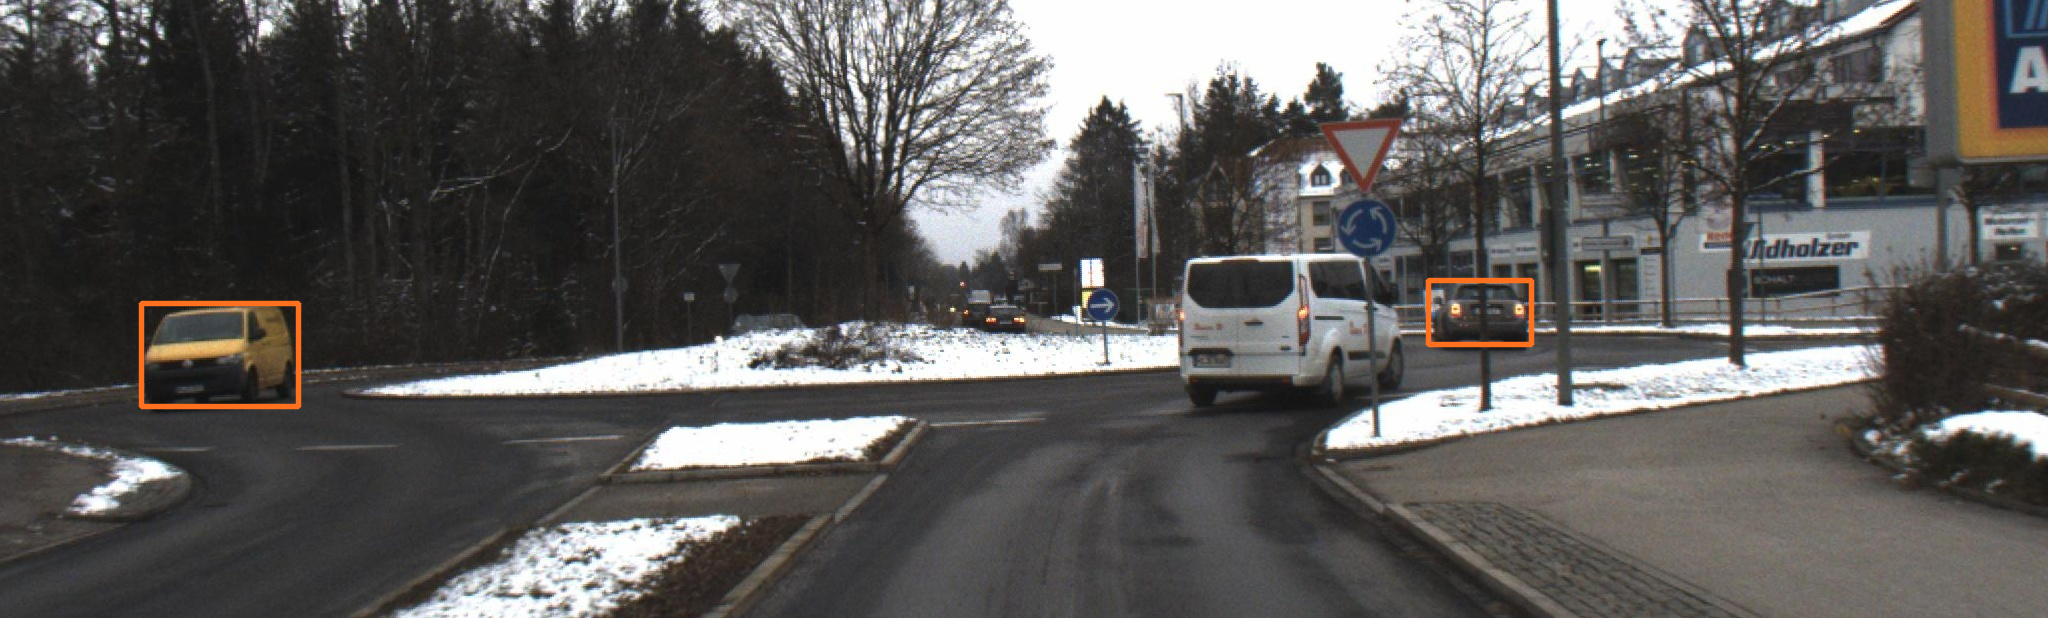

In [136]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s' , pretrained=True)
    # Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.conf = 0.385  # NMS confidence threshold
model.iou = 0.55  # NMS IoU threshold
model.classes = [2, 3, 5, 7]  # Filter by classes for car, motorcycle, bus, and truck respectively
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # Maximum number of detections per image
# Images
imgs = [f'./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{L}.jpg']  # batch of images

# Inference
results = model(imgs)

# Show detected objects
results.show(labels=False)
results.xyxy[0]  # img1 predictions (tensor)
# Filter detected objects for cars, trucks, motorcycles, and buses only
df = results.pandas().xyxy[0]
df_filtered = df[(df['name'] == 'car') | (df['name'] == 'motorcycle') | (df['name'] == 'bus') | (df['name'] == 'truck')]
# Define output path
output_path = f'./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/{L}.csv'

# Save DataFrame to CSV
df.to_csv(output_path, index=False)

# Class Calculation

In [137]:
class calib_astyx():
    def __init__(self, file):
        # Initialize the calibration object by loading sensor calibration data from a JSON file.
        # Parameters:
        # - file: A string path to the JSON file containing calibration data for radar, lidar, and camera sensors.

        # Load calibration data from a JSON file
        with open(file) as json_file:
            data = json.load(json_file)
            
        # Calibration matrices for converting radar, lidar, and camera data to a reference coordinate system
        self.radar2ref = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])  # Radar to reference
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])  # Lidar to reference (COS means Coordinate System)
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])  # Camera to reference
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])  # Intrinsic camera matrix
        
        # Compute inverse transformations for mapping from the reference coordinate system back to sensor-specific coordinate systems
        self.ref2radar = self.inv_trans(self.radar2ref)
        self.ref2lidar = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        # Compute the inverse transformation matrix for a given sensor to reference coordinate transformation.
        # Parameters:
        # - T: A numpy array representing the transformation matrix from sensor to reference coordinates.
        # Returns:
        # - The inverse transformation matrix as a numpy array, which can be used to map points from the
        # reference coordinate system back to the sensor-specific coordinate system.

        rotation = np.linalg.inv(T[0:3, 0:3])  # Invert the rotation part
        translation = T[0:3, 3]
        translation = -1 * np.dot(rotation, translation.T)  # Invert the translation part
        translation = np.reshape(translation, (3, 1))
        Q = np.hstack((rotation, translation))  # Reassemble the inverted transformation matrix

        return Q


    def lidar2ref(self, points):
        # Convert lidar points from the lidar coordinate system to the reference coordinate system.
        # Parameters:
        # - points: A numpy array of points in the lidar coordinate system.
        # Returns:
        # - A numpy array of the same points transformed to the reference coordinate system.

        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.lidar2ref_cos))  # Transform points to reference coordinate system
        
        return points_ref[:,0:3]  # Return the transformed points, discarding the homogeneous coordinate
    
    def radar2ref(self, points):
        """
        Convert radar points from the radar coordinate system to the reference coordinate system.
        Parameters:
        - points: A numpy array of points in the radar coordinate system.
        Returns:
        - A numpy array of the same points transformed to the reference coordinate system.
        """
        n = points.shape[0]
        points_hom = np.hstack((points, np.ones((n, 1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.radar2ref))  # Transform points to reference coordinate system
        return points_ref[:, 0:3]  # Return the transformed points, discarding the homogeneous coordinate


    def ref2Camera(self, points, img_size):
        # Project points from the reference coordinate system onto the camera image plane.
        # Parameters:
        # - points: A numpy array of points in the reference coordinate system.
        # - img_size: A tuple representing the size of the camera image (width, height).
        # Returns:
        # - A tuple containing a numpy array of the projected points on the camera image plane and a mask
        # array indicating which points are within the image frame.

        obj_image = np.dot(self.ref2camera[0:3, 0:3], points.T)  # Apply rotation
        T = self.ref2camera[0:3, 3]
        obj_image = obj_image + T[:, np.newaxis]  # Apply translation
        obj_image = np.dot(self.K, obj_image)  # Apply intrinsic camera matrix
        obj_image = obj_image / obj_image[2]  # Normalize by the third row to project onto image plane
        obj_image = np.delete(obj_image, 2, 0)  # Remove the third row
        
        # Create a mask to filter out points that are outside the image frame or behind the camera
        mask = (obj_image[0,:] <= img_size[0]) & \
               (obj_image[1,:] <= img_size[1]) & \
               (obj_image[0,:] >= 0) & (obj_image[1,:] >= 0) & \
               (points[:,0] >= 0)
        return obj_image, mask  # Return the projected points and the mask


# Object Calculation

In [138]:
class Object3d(object):
    """
    Represents a 3D object with attributes extracted from a given input dictionary.
    This class handles the extraction and manipulation of various object properties,
    including its orientation, bounding box, and angle calculations based on quaternion
    orientation data.

    Attributes:
    - type (str): The class name of the object.
    - occlusion (float): The occlusion level of the object.
    - quat (numpy.ndarray): Quaternion representing the object's orientation.
    - rotationmatrix (numpy.ndarray): Rotation matrix derived from the quaternion.
    - h (float): Height of the object's bounding box.
    - w (float): Width of the object's bounding box.
    - l (float): Length of the object's bounding box.
    - t (tuple): A tuple representing the center of the object's bounding box.
    - distance (float): Distance of the object from the origin, calculated using its bounding box center.
    - bbox (numpy.ndarray): Coordinates of the object's bounding box corners.
    - angle (float): Angle of the object's orientation in degrees.
    """
    def __init__(self, obj):
        """
        Initializes an Object3d instance by extracting relevant attributes from the input dictionary.

        Parameters:
        - obj (dict): A dictionary containing object properties, including its class name,
                      dimensions, center, occlusion level, and orientation quaternion.
        """
        # Extract basic attributes
        self.type = obj["classname"]
        self.occlusion = obj["occlusion"] 
        self.quat = np.array(obj["orientation_quat"])
        self.rotationmatrix = self.get_rotationmatrix()
        
        # Extract 3D bounding box information
        self.h = obj["dimension3d"][2]  # box height
        self.w = obj["dimension3d"][1]  # box width
        self.l = obj["dimension3d"][0]  # box length (in meters)
        self.t = (obj["center3d"][0], obj["center3d"][1], obj["center3d"][2])
        
        self.distance = np.sqrt(np.sum(np.square(self.t)))
        
        # Calculate bounding box corners and object's angle
        self.bbox = self.get_bbox()
        self.angle = self.get_angle()[2]
        if self.angle >= 0:
            self.angle = self.angle * 180 / np.pi
        else:
            self.angle = self.angle * 180 / np.pi + 360

    def get_angle(self):
        """
        Calculates the Euler angles from the object's orientation quaternion.

        Returns:
        - A tuple of Euler angles (roll, pitch, yaw) in radians.
        """
        w, x, y, z = self.quat
        return (math.atan2(2*(w*x+y*z), 1-2*(x*x+y*y)),
                math.asin(2*(w*y-z*x)),
                math.atan2(2*(w*z+x*y), 1-2*(y*y+z*z)))

    def get_bbox(self):
        """
        Calculates the coordinates of the object's bounding box corners based on its
        center, dimensions, and orientation.

        Returns:
        - A numpy.ndarray containing the coordinates of the bounding box corners.
        """
        center = np.array(self.t)
        dimension = np.array([self.l, self.w, self.h])

        # Adjust dimensions for bounding box calculation
        w, l, h = dimension[0] + 0.1, dimension[1] + 0.1, dimension[2]

        # Define corner points in local object coordinates
        x_corners = [-w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2]
        y_corners = [l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2]
        z_corners = [h / 2, h / 2, h / 2, -h / 2, -h / 2, -h / 2, -h / 2, h / 2]

        # Apply rotation and translate to global coordinates
        R = self.rotationmatrix
        bbox = np.vstack([x_corners, y_corners, z_corners])
        bbox = np.dot(R, bbox)
        bbox = bbox + center[:, np.newaxis]
        bbox = np.transpose(bbox)

        return bbox
    
    def get_rotationmatrix(self):
        """
        Converts the object's orientation quaternion into a rotation matrix.

        Returns:
        - A numpy.ndarray representing the rotation matrix.
        """
        n = np.dot(self.quat, self.quat)
        if n < np.finfo(self.quat.dtype).eps:
            return np.identity(4)  # Return identity matrix if quaternion is near zero
        
        q = self.quat * np.sqrt(2.0 / n)
        q = np.outer(q, q)
        rot_matrix = np.array(
            [[1.0 - q[2, 2] - q[3, 3], q[1, 2] + q[3, 0], q[1, 3] - q[2, 0]],
             [q[1, 2] - q[3, 0], 1.0 - q[1, 1] - q[3, 3], q[2, 3] + q[1, 0]],
             [q[1, 3] + q[2, 0], q[2, 3] - q[1, 0], 1.0 - q[1, 1] - q[2, 2]]],
            dtype=q.dtype)
        rot_matrix = np.transpose(rot_matrix)
        return rot_matrix

class calib_astyx():
    """
    This class is designed to manage the calibration of sensor data in autonomous vehicle contexts.
    
    It supports the conversion of sensor data between different coordinate systems, specifically for radar,
    lidar, and camera sensors, to a common reference coordinate system and vice versa. It also handles the
    projection of points from the reference coordinate system onto the camera image plane.
    """
    
    def __init__(self, file):
        """
        Initialize the calibration object by loading sensor calibration data from a JSON file.
        
        Parameters:
        - file: A string path to the JSON file containing calibration data for radar, lidar, and camera sensors.
        
        The method extracts transformation matrices for each sensor to the reference coordinate system and
        the intrinsic camera matrix.
        """
        # Load calibration data from a JSON file
        with open(file) as json_file:
            data = json.load(json_file)
            
        # Calibration matrices for converting radar, lidar, and camera data to a reference coordinate system
        self.radar2ref_cos = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])  # Radar to reference
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])  # Lidar to reference (COS means Coordinate System)
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])  # Camera to reference
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])  # Intrinsic camera matrix
        
        # Compute inverse transformations for mapping from the reference coordinate system back to sensor-specific coordinate systems
        self.ref2radar = self.inv_trans(self.radar2ref_cos)
        self.ref2lidar = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        """
        Compute the inverse transformation matrix for a given sensor to reference coordinate transformation.
        
        Parameters:
        - T: A numpy array representing the transformation matrix from sensor to reference coordinates.
        
        Returns:
        - The inverse transformation matrix as a numpy array, which can be used to map points from the
          reference coordinate system back to the sensor-specific coordinate system.
        """
        rotation = np.linalg.inv(T[0:3, 0:3])  # Invert the rotation part
        translation = T[0:3, 3]
        translation = -1 * np.dot(rotation, translation.T)  # Invert the translation part
        translation = np.reshape(translation, (3, 1))
        Q = np.hstack((rotation, translation))  # Reassemble the inverted transformation matrix

        return Q
    
    def lidar2ref(self, points):
        """
        Convert lidar points from the lidar coordinate system to the reference coordinate system.
        
        Parameters:
        - points: A numpy array of points in the lidar coordinate system.
        
        Returns:
        - A numpy array of the same points transformed to the reference coordinate system.
        """
        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.lidar2ref_cos))  # Transform points to reference coordinate system
        
        return points_ref[:,0:3]  # Return the transformed points, discarding the homogeneous coordinate
    
    def radar2ref(self, points):
        # Convert radar points from the radar coordinate system to the reference coordinate system.
        # Parameters:
        # - points: A numpy array of points in the radar coordinate system.
        # Returns:
        # - A numpy array of the same points transformed to the reference coordinate system.

        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.radar2ref_cos))  # Transform points to reference coordinate system
        
        return points_ref[:,0:3]  # Return the transformed points, discarding the homogeneous coordinate

    def ref2Camera(self, points, img_size):
        """
        Project points from the reference coordinate system onto the camera image plane.
        
        Parameters:
        - points: A numpy array of points in the reference coordinate system.
        - img_size: A tuple representing the size of the camera image (width, height).
        
        Returns:
        - A numpy array of projected points on the camera image plane.
        - A boolean mask indicating whether each point is visible in the camera image.
        """
        n = points.shape[0]
        
        # Convert points to homogeneous coordinates
        points_hom = np.hstack((points, np.ones((n,1))))
        
        # Transform points to camera coordinate system
        points_camera = np.dot(points_hom, np.transpose(self.ref2camera))
        
        # Project points onto camera image plane
        projected_points = np.dot(points_camera, np.transpose(self.K))
        projected_points = projected_points[:, 0:2] / projected_points[:, 2][:, None]
        
        # Create mask to filter out points outside the image boundaries
        mask = (projected_points[:, 0] >= 0) & (projected_points[:, 0] < img_size[0]) & \
               (projected_points[:, 1] >= 0) & (projected_points[:, 1] < img_size[1])
        
        return projected_points, mask


# LIdar Point Converstion To Image

In [139]:
# Load calibration data
calib = calib_astyx(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/calibration/{L}.json")

# Load lidar data from text file
lidar = np.loadtxt(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{L}.txt", skiprows=1)

lidar_points = lidar[:, :3]  # Selecting only the first three points
lidar_points_ref = calib.lidar2ref(lidar_points)
#print(lidar_points_ref)

# Load camera image using OpenCV
img = cv2.imread(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{L}.jpg")  

# Get the height and width of the image
img_height, img_width = img.shape[:2]

# Project lidar points onto camera image
projected_points, mask = calib.ref2Camera(lidar_points_ref, (img_width, img_height))



# Dispaly Lidar Point in Image 

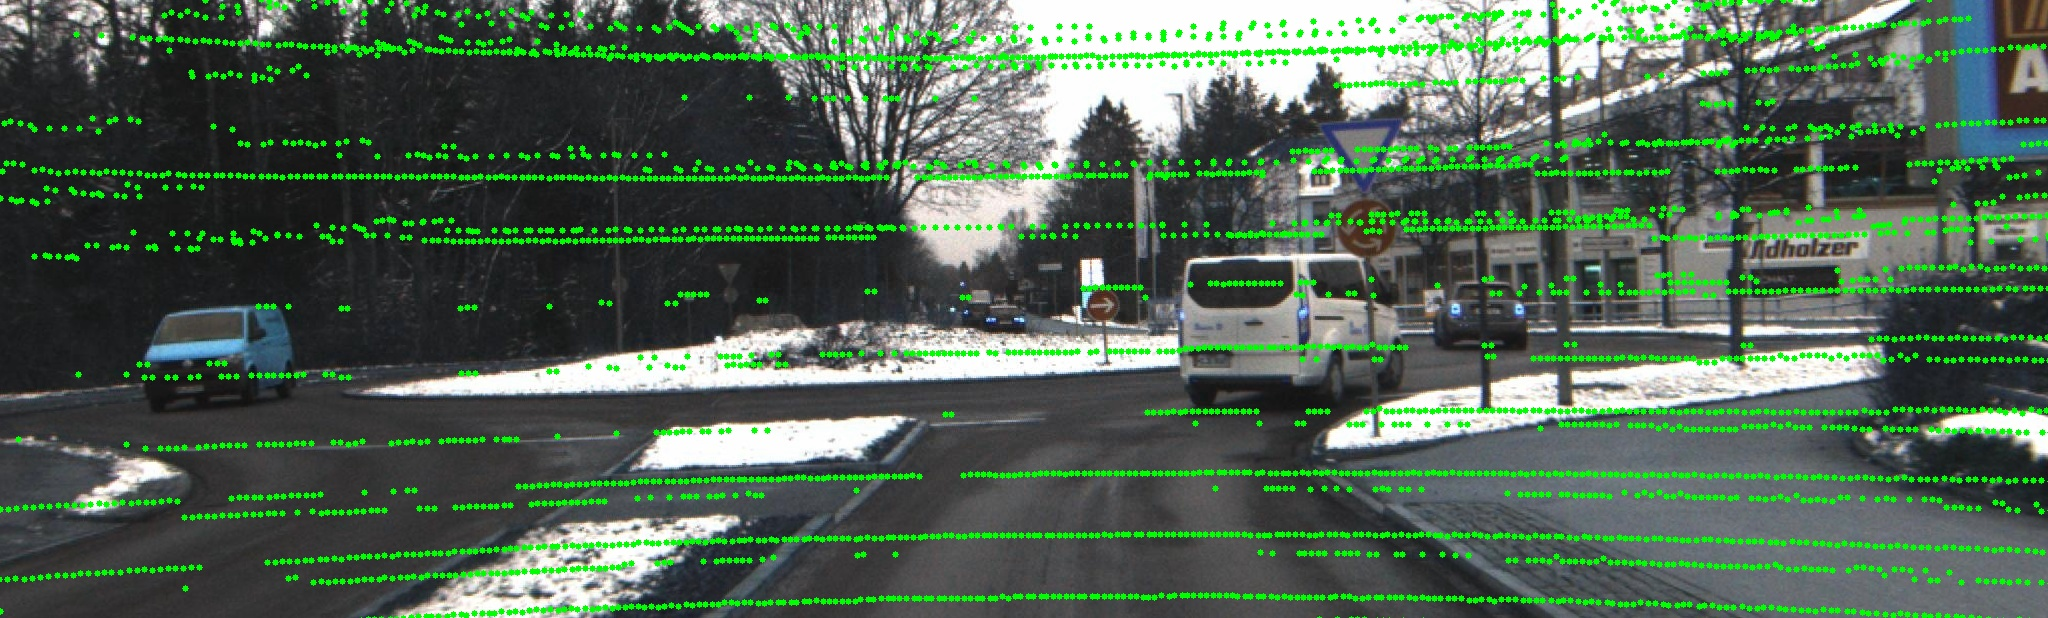

In [140]:
# Convert projected points to integers for pixel coordinates
projected_points_int = projected_points.astype(int)


# Draw projected lidar points on the image
for point in projected_points_int:
    cv2.circle(img, (point[0], point[1]), radius=3, color=(0, 255, 0), thickness=-1)

# Convert OpenCV image to RGB format
img_rgb_l = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
display(Image(data=cv2.imencode('.jpg', img_rgb_l)[1]))


# Filtearing Lidar Point

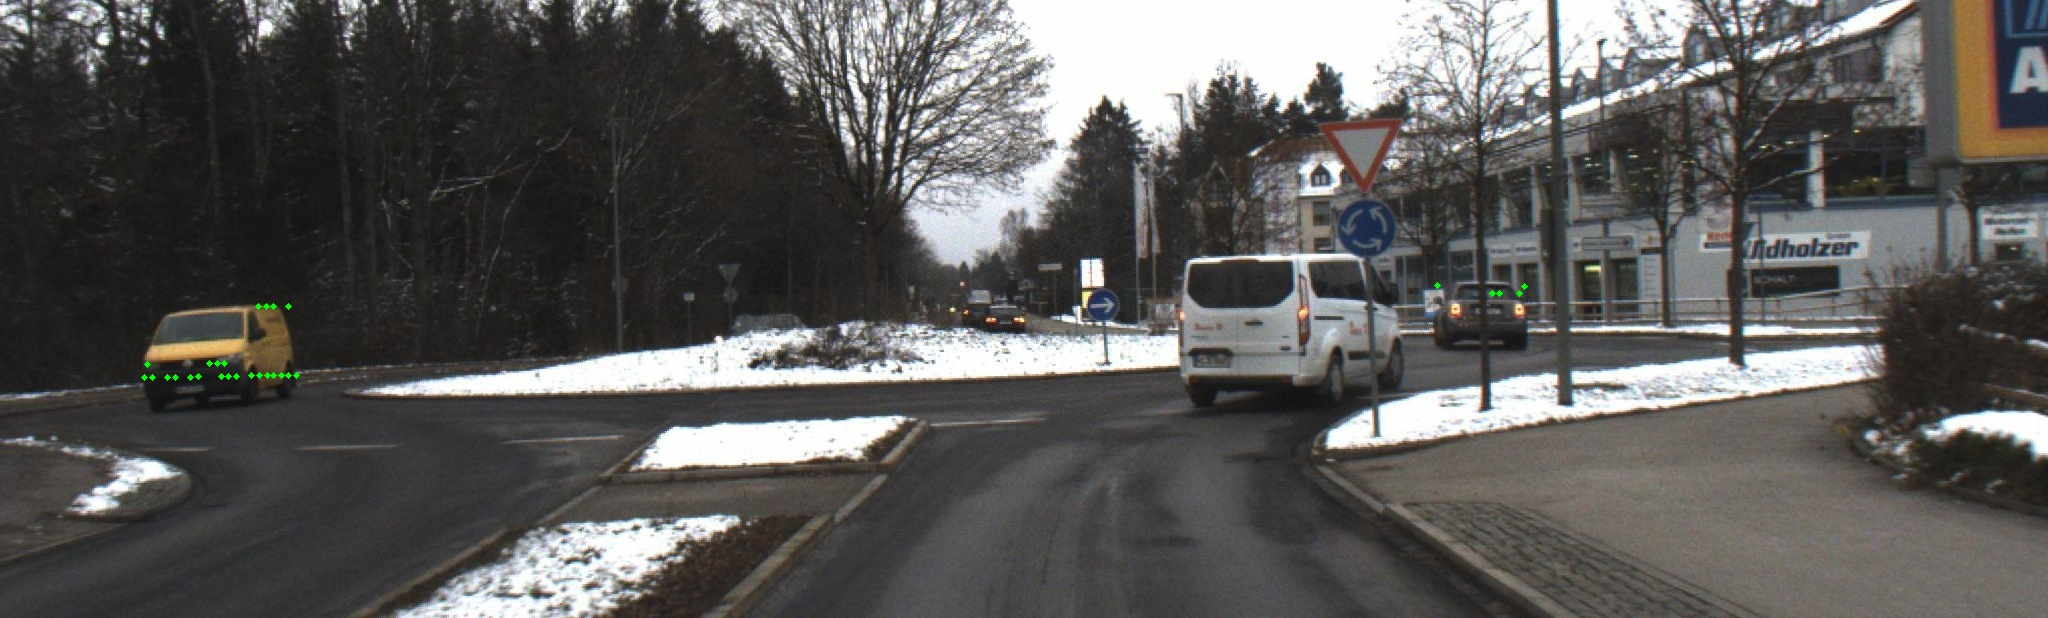

In [141]:
bbox_data = pd.read_csv(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/{L}.csv")

img_lidar=cv2.imread(f'./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{L}.jpg')
# Store bounding box coordinates
BB_Coor = bbox_data[['xmin', 'ymin', 'xmax', 'ymax']].values

# Read lidar projected points
lidar_points = projected_points_int  # Assuming you already have this variable
# Store lidar projected points
Lidar_Fil = lidar_points.copy()

# Compare bounding box coordinates and lidar points
Fused_BB_Li = []
for point in Lidar_Fil:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coor:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            Fused_BB_Li.append(point)
            break

# Store the filtered lidar points in Fused_BB_Li
Fused_BB_Li = np.array(Fused_BB_Li)

# Draw lidar points inside bounding box on copied image
for point in Fused_BB_Li:
    cv2.circle(img_lidar, (point[0], point[1]), radius=1, color=(0, 255, 0), thickness=3)

# Display the image with filtered lidar points inside the bounding box
display(Image(data=cv2.imencode('.jpg', img_lidar)[1]))

# Conversion of Radar point onto Image

In [142]:
# Load calibration data
calib = calib_astyx(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/calibration/{L}.json")

# Load lidar data from text file
radar = np.loadtxt(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{L}.txt", skiprows=2)

radar_points = radar[:, :3]  # Selecting only the first three points
radar_points_ref = calib.radar2ref(radar_points)

# Load camera image using OpenCV
imgage = cv2.imread(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{L}.jpg")  

# Get the height and width of the image
img_height, img_width = imgage.shape[:2]

# Project lidar points onto camera image
projected_points, mask = calib.ref2Camera(radar_points_ref, (img_width, img_height))



# Dispalying Radar Point onto Image

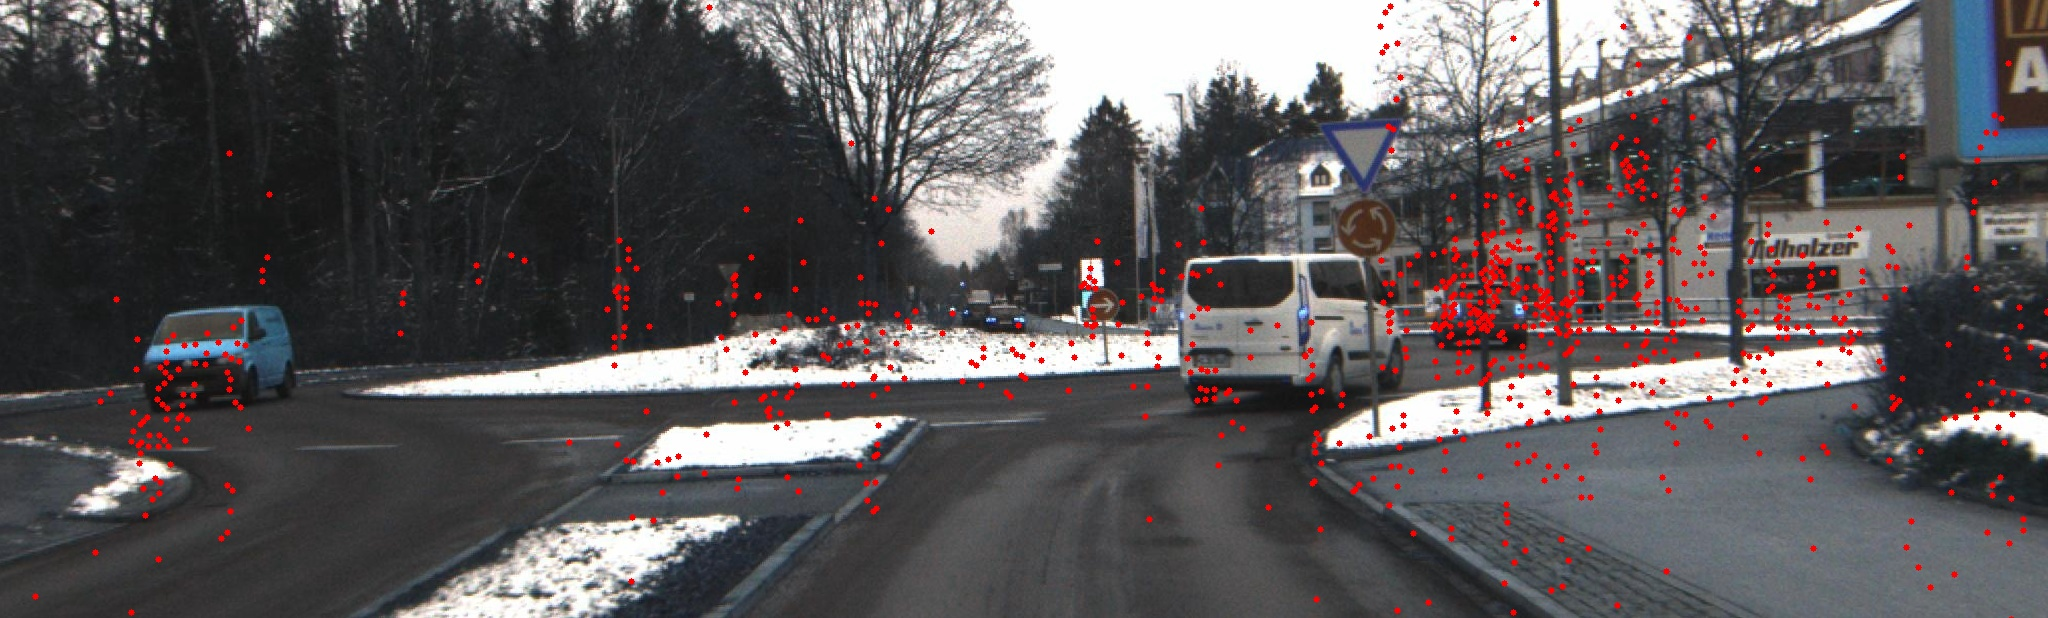

In [143]:


# Convert projected points to integers for pixel coordinates
projected_points_int_radar = projected_points.astype(int)

# Draw projected lidar points on the image
for point in projected_points_int_radar:
    cv2.circle(imgage, (point[0], point[1]), radius=3, color=(255, 0, 0), thickness=-1)

# Convert OpenCV image to RGB format
img_rgb_r = cv2.cvtColor(imgage, cv2.COLOR_BGR2RGB)

# Display the image
display(Image(data=cv2.imencode('.jpg', img_rgb_r)[1]))

# Filtering radar Points

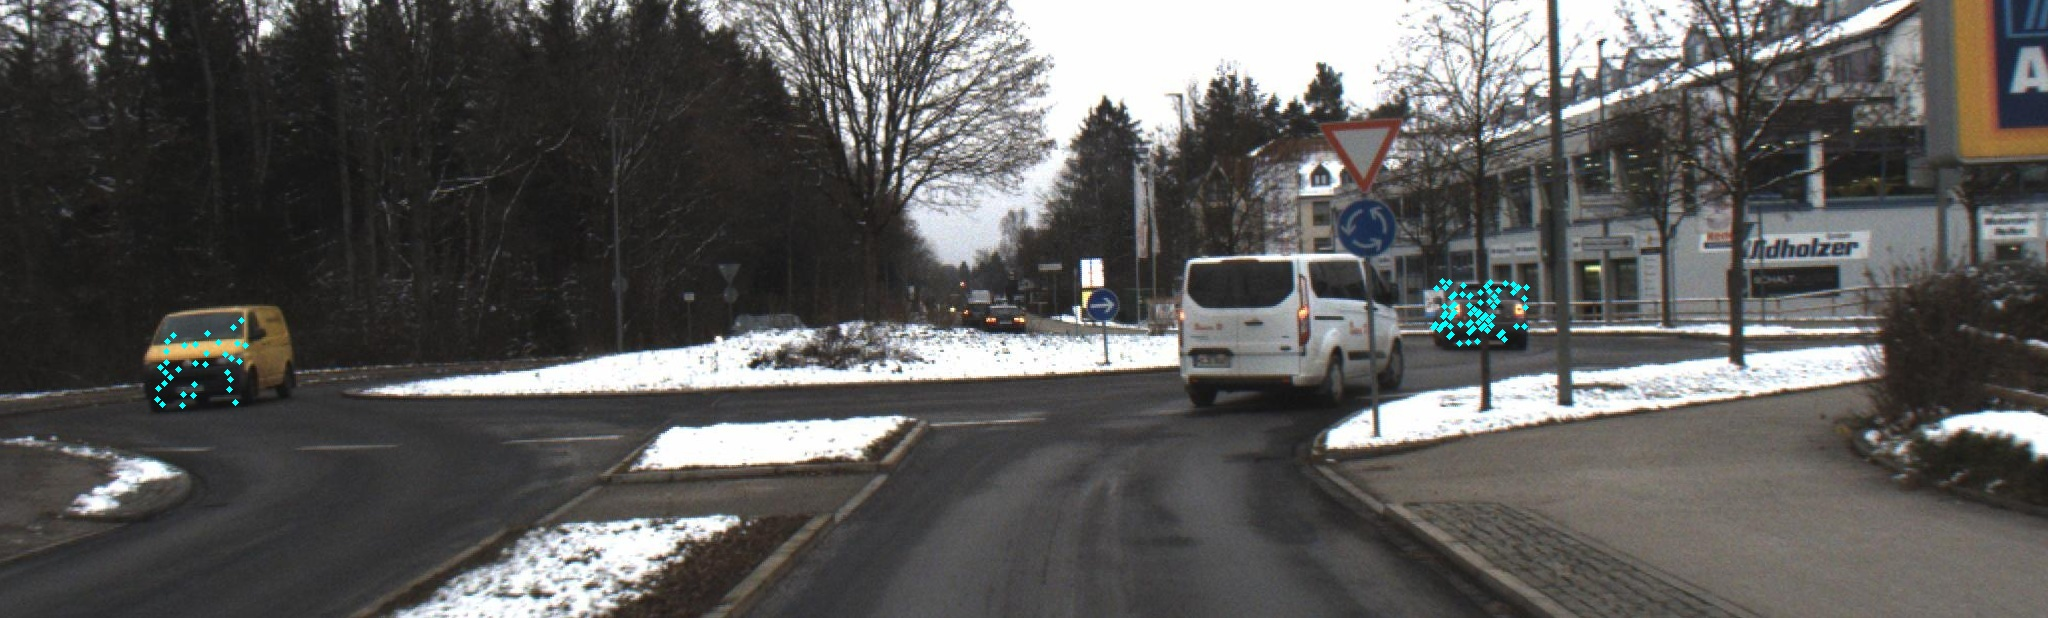

In [144]:
bbox_data = pd.read_csv(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/{L}.csv")

img_radar=cv2.imread(f'./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/{L}.jpg')

# Store bounding box coordinates
BB_Coor = bbox_data[['xmin', 'ymin', 'xmax', 'ymax']].values

# Read radar projected points
radar_points = projected_points_int_radar  # Assuming you already have this variable

# Store Radar projected points
Radar_Fil = radar_points.copy()

# Compare bounding box coordinates and lidar points
Fused_BB_RA = []
for point in Radar_Fil:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coor:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            Fused_BB_RA.append(point)
            break

# Store the filtered lidar points in Fused_BB_Li
Fused_BB_RA = np.array(Fused_BB_RA)


# Draw lidar points inside bounding box on copied image
for point in Fused_BB_RA:
    cv2.circle(img_radar, (point[0], point[1]), radius=1, color=(255, 255, 0), thickness=3)

# Display the image with filtered lidar points inside the bounding box
display(Image(data=cv2.imencode('.jpg', img_radar)[1]))

# Blended Lidar And Radar Point in one Image

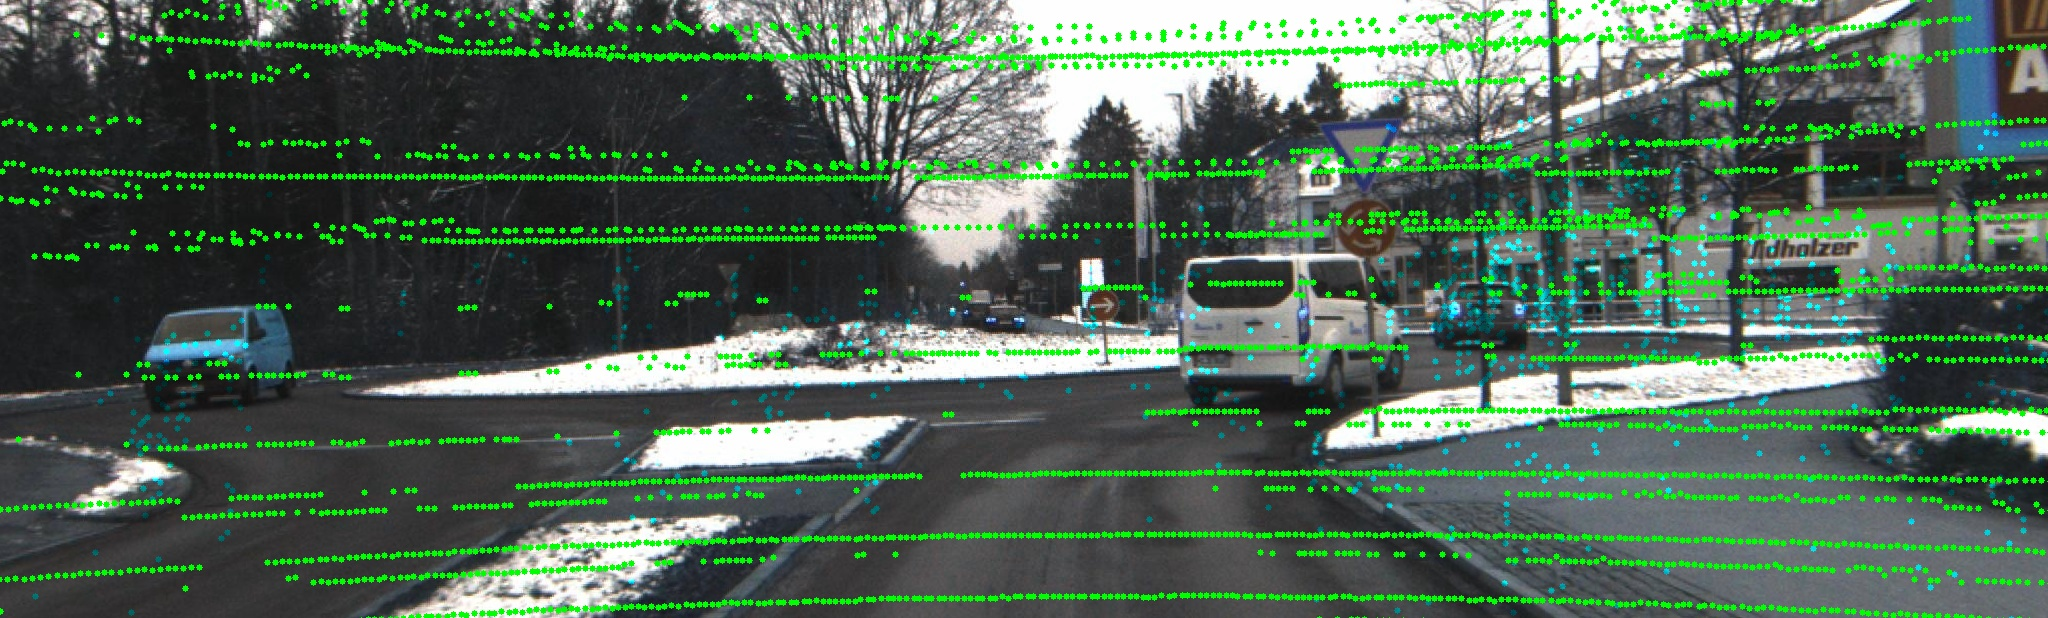

In [145]:
# Blend the images using alpha blending
alpha = 2  # Adjust the alpha value for blending
blended_img = cv2.addWeighted(img_rgb_l, alpha, img_rgb_r, 1 - alpha, 0)

# Display the blended image
display(Image(data=cv2.imencode('.jpg', blended_img)[1]))

# Filter Radar and Lidar Fused point

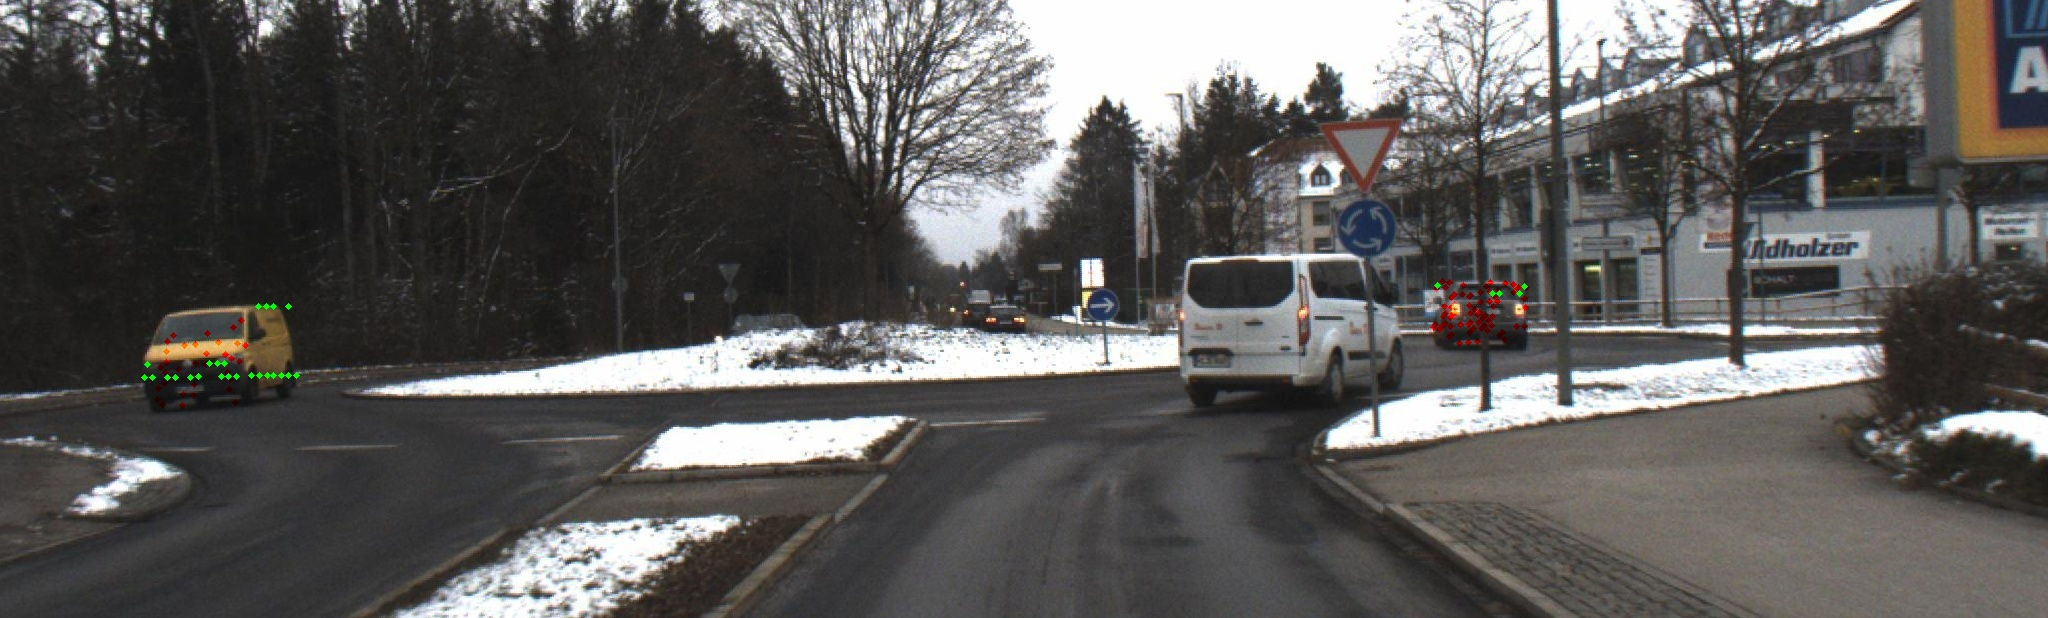

In [146]:
# Blend the images using alpha blending
alpha = 2  # Adjust the alpha value for blending
blended_img_li_ra = cv2.addWeighted(img_lidar, alpha, img_radar, 1 - alpha, 0)

# Display the blended image
display(Image(data=cv2.imencode('.jpg', blended_img_li_ra)[1]))

# Distance Estimation Lidar and Radar

# Lidar Distance Estimation

In [147]:
'''# Load lidar data from text file
lidar_v = np.loadtxt("./dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000000.txt", skiprows=1)

# Store lidar points in Lidar_d
Lidar_d = lidar_v[:, :3]

# Transform lidar points to the reference coordinate system
lidar_d_ref = calib.lidar2ref(Lidar_d)

# Print the transformed lidar points (Refrence co-ordinates)
#print(lidar_d_ref)

# Project lidar points onto camera image
projected_points, mask = calib.ref2Camera(lidar_d_ref, (img_width, img_height))

# Convert projected points to integers for pixel coordinates
Lidar_d_2d = projected_points.astype(int)
#print(Lidar_d_2d)

BB = pd.read_csv(r"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/000000.csv")

# Extract bounding box coordinates from DataFrame
BB_Coordinates = bbox_data[['xmin', 'ymin', 'xmax', 'ymax']].values
#print(BB_Coordinates)

# Initialize list to store filtered lidar points
lidar_fildistance = []

# Compare bounding box coordinates and lidar points
for point in Lidar_d_2d:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coordinates:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            lidar_fildistance.append(point)
            break

# Convert filtered lidar points to NumPy array
lidar_fildistance = np.array(lidar_fildistance)

#print(lidar_fildistance)
# Create a dictionary to store Lidar points for each bounding box
lidar_by_bbox = {}

# Iterate through each bounding box
for i, (xmin, ymin, xmax, ymax) in enumerate(BB_Coordinates):
    # Filter Lidar points that fall within the current bounding box
    points_in_bbox = lidar_fildistance[
        (lidar_fildistance[:, 0] >= xmin) & (lidar_fildistance[:, 0] <= xmax) &
        (lidar_fildistance[:, 1] >= ymin) & (lidar_fildistance[:, 1] <= ymax)
    ]
    # Store the filtered Lidar points for the current bounding box
    lidar_by_bbox[f'BoundingBox_{i+1}'] = points_in_bbox

# Print Lidar points separated by bounding box rows
for bbox, points in lidar_by_bbox.items():
    print(f"Points within {bbox}:")
    print(points)
    print()
'''


'# Load lidar data from text file\nlidar_v = np.loadtxt("./dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000000.txt", skiprows=1)\n\n# Store lidar points in Lidar_d\nLidar_d = lidar_v[:, :3]\n\n# Transform lidar points to the reference coordinate system\nlidar_d_ref = calib.lidar2ref(Lidar_d)\n\n# Print the transformed lidar points (Refrence co-ordinates)\n#print(lidar_d_ref)\n\n# Project lidar points onto camera image\nprojected_points, mask = calib.ref2Camera(lidar_d_ref, (img_width, img_height))\n\n# Convert projected points to integers for pixel coordinates\nLidar_d_2d = projected_points.astype(int)\n#print(Lidar_d_2d)\n\nBB = pd.read_csv(r"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/000000.csv")\n\n# Extract bounding box coordinates from DataFrame\nBB_Coordinates = bbox_data[[\'xmin\', \'ymin\', \'xmax\', \'ymax\']].values\n#print(BB_Coordinates)\n\n# Initialize list to store filtered lidar points\nlidar_fildistance = []\n\n# Compare bounding box

# Store Correspoinding Lidar Points (X,Y,Z)

In [148]:
'''# Initialize a dictionary to store combined lidar points for each bounding box
com_lidar_by_bbox = {}

# Iterate through each pixel coordinate in lidar_fildistance
for u, v in lidar_fildistance:
    # Find the corresponding index in the original lidar points array based on the pixel coordinates
    index = np.where((Lidar_d_2d[:, 0] == u) & (Lidar_d_2d[:, 1] == v))[0][0]

    # Retrieve the corresponding lidar point (X, Y, Z) from the original lidar data
    x, y, z = Lidar_d[index]

    # Determine which bounding box the lidar point falls into
    point_assigned = False
    for i, (xmin, ymin, xmax, ymax) in enumerate(BB_Coordinates):
        if xmin <= u <= xmax and ymin <= v <= ymax:
            # Append the combined lidar point (X, Y, Z) to the corresponding bounding box
            bbox_key = f'BoundingBox_{i+1}'
            if bbox_key not in com_lidar_by_bbox:
                com_lidar_by_bbox[bbox_key] = []
            com_lidar_by_bbox[bbox_key].append([x, y, z])
            point_assigned = True
            break
    
    # If the lidar point doesn't fall within any bounding box, do nothing
    if not point_assigned:
        pass

# Convert the dictionary of combined lidar points by bounding box to NumPy arrays
for bbox_key, points in com_lidar_by_bbox.items():
    com_lidar_by_bbox[bbox_key] = np.array(points)

# Print combined lidar points separated by bounding box
for bbox_key, points in com_lidar_by_bbox.items():
    print(f"Lidar points within {bbox_key}:")
    print(points)
    print()
'''


'# Initialize a dictionary to store combined lidar points for each bounding box\ncom_lidar_by_bbox = {}\n\n# Iterate through each pixel coordinate in lidar_fildistance\nfor u, v in lidar_fildistance:\n    # Find the corresponding index in the original lidar points array based on the pixel coordinates\n    index = np.where((Lidar_d_2d[:, 0] == u) & (Lidar_d_2d[:, 1] == v))[0][0]\n\n    # Retrieve the corresponding lidar point (X, Y, Z) from the original lidar data\n    x, y, z = Lidar_d[index]\n\n    # Determine which bounding box the lidar point falls into\n    point_assigned = False\n    for i, (xmin, ymin, xmax, ymax) in enumerate(BB_Coordinates):\n        if xmin <= u <= xmax and ymin <= v <= ymax:\n            # Append the combined lidar point (X, Y, Z) to the corresponding bounding box\n            bbox_key = f\'BoundingBox_{i+1}\'\n            if bbox_key not in com_lidar_by_bbox:\n                com_lidar_by_bbox[bbox_key] = []\n            com_lidar_by_bbox[bbox_key].append([x

In [149]:
# Load lidar data from text file
lidar_data = np.loadtxt(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/{L}.txt", skiprows=1)

# Store lidar points in lidar_points variable
lidar_points = lidar_data[:, :3]

# Transform lidar points to the reference coordinate system
lidar_points_ref = calib.lidar2ref(lidar_points)

# Project lidar points onto camera image
projected_points, mask = calib.ref2Camera(lidar_points_ref, (img_width, img_height))

# Convert projected points to integers for pixel coordinates
lidar_points_2d = projected_points.astype(int)
#print(lidar_points_2d)

# Extract bounding box coordinates from DataFrame
BB = pd.read_csv(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/{L}.csv")
BB_Coordinates = BB[['xmin', 'ymin', 'xmax', 'ymax']].values

# Initialize list to store filtered lidar points
filtered_lidar_points = []

# Compare bounding box coordinates and lidar points
for point in lidar_points_2d:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coordinates:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            filtered_lidar_points.append(point)
            break

# Convert filtered lidar points to NumPy array
filtered_lidar_points = np.array(filtered_lidar_points)

#print(filtered_lidar_points)


In [150]:
# Initialize a dictionary to store combined lidar points for each bounding box
com_lidar_by_bbox = {}

# Initialize a flag to keep track of whether any points were found for each bounding box
points_found = False
print(lidar_points_2d)
#print(filtered_lidar_points)
# Iterate through each pixel coordinate in filtered_lidar_points
for u, v in filtered_lidar_points:
    # Find the corresponding index in the original lidar points array based on the pixel coordinates
    index = np.where((lidar_points_2d[:, 0] == u) & (lidar_points_2d[:, 1] == v))[0][0]
    print(lidar_points[index])
    # Retrieve the corresponding lidar point (X, Y, Z) from the original lidar data
    x, y, z = lidar_points[index]
    print(lidar_points[index])
    # Determine which bounding box the lidar point falls into
    point_assigned = False
    for i, (xmin, ymin, xmax, ymax) in enumerate(BB_Coordinates):
        if xmin <= u <= xmax and ymin <= v <= ymax:
            # Append the combined lidar point (X, Y, Z) to the corresponding bounding box
            bbox_key = f'BoundingBox_{i+1}'
            if bbox_key not in com_lidar_by_bbox:
                com_lidar_by_bbox[bbox_key] = []
            com_lidar_by_bbox[bbox_key].append([x, y, z])
            point_assigned = True
            points_found = True  # Set flag to True if points are found for this bounding box
            break
    
    # If the lidar point doesn't fall within any bounding box, do nothing
    if not point_assigned:
        pass

# Convert the dictionary of combined lidar points by bounding box to NumPy arrays
for bbox_key, points in com_lidar_by_bbox.items():
    # Convert the key to a NumPy array
    bbox_key_array = np.array([bbox_key] * len(points))
    # Convert the lidar points to a NumPy array
    points_array = np.array(points)
    # Combine the key array and the points array horizontally
    combined_array = np.hstack((bbox_key_array[:, np.newaxis], points_array))
    # Update the dictionary with the combined array
    com_lidar_by_bbox[bbox_key] = combined_array
    


# Print combined lidar points separated by bounding box or a message if no points are found
for bbox_key, points in com_lidar_by_bbox.items():
    print(f"Lidar points within {bbox_key}:")
    print(points)
    print()

# If no points are found for any bounding box, print a message
if not points_found:
    print("No lidar points found within any bounding box.")


[[1163   32]
 [1162   54]
 [1165  177]
 ...
 [1156   55]
 [1162  224]
 [1157  174]]
[     -46.57        8.49       -0.83]
[     -46.57        8.49       -0.83]
[     -46.64        8.67       -0.83]
[     -46.64        8.67       -0.83]
[     -44.39        8.73       -0.79]
[     -44.39        8.73       -0.79]
[      32.69       18.68       -0.66]
[      32.69       18.68       -0.66]
[      33.05       17.68       -0.65]
[      33.05       17.68       -0.65]
[      33.18        17.6       -0.66]
[      33.18        17.6       -0.66]
[      33.24       17.49       -0.66]
[      33.24       17.49       -0.66]
[      54.75       -8.34        0.97]
[      54.75       -8.34        0.97]
[      83.12      -16.53        1.48]
[      83.12      -16.53        1.48]
[     -24.45      -14.11        0.49]
[     -24.45      -14.11        0.49]
[     -24.04      -13.76        0.48]
[     -24.04      -13.76        0.48]
[     -25.49      -14.36        0.51]
[     -25.49      -14.36        0.51]
[   

# Lidar Medain

In [151]:

'''# Initialize a dictionary to store the median of X coordinates for each bounding box
x_median_by_bbox = {}

# Iterate through each bounding box
for bbox_key, points in com_lidar_by_bbox.items():
    # Extract X coordinates from the combined Lidar points within the current bounding box
    x_coordinates = points[:, 0]
    
    # Calculate the median of X coordinates for the current bounding box
    median_x = np.mean(abs(x_coordinates))
    
    # Store the median of X coordinates for the current bounding box
    x_median_by_bbox[f"Median of X coordinates for lidar {bbox_key}"] = median_x

# Print the median of X coordinates for each bounding box
for bbox_key, median_x in x_median_by_bbox.items():
    print(f"{bbox_key}: {median_x}")

#print("Median of X coordinates for lidar:", x_median_lidar)
'''




'# Initialize a dictionary to store the median of X coordinates for each bounding box\nx_median_by_bbox = {}\n\n# Iterate through each bounding box\nfor bbox_key, points in com_lidar_by_bbox.items():\n    # Extract X coordinates from the combined Lidar points within the current bounding box\n    x_coordinates = points[:, 0]\n    \n    # Calculate the median of X coordinates for the current bounding box\n    median_x = np.mean(abs(x_coordinates))\n    \n    # Store the median of X coordinates for the current bounding box\n    x_median_by_bbox[f"Median of X coordinates for lidar {bbox_key}"] = median_x\n\n# Print the median of X coordinates for each bounding box\nfor bbox_key, median_x in x_median_by_bbox.items():\n    print(f"{bbox_key}: {median_x}")\n\n#print("Median of X coordinates for lidar:", x_median_lidar)\n'

In [152]:
# Initialize a dictionary to store the median of X coordinates for lidar for each bounding box
x_median_lidar_by_bbox = {}

# Iterate through each bounding box
for bbox_key, points in com_lidar_by_bbox.items():
    # Extract X coordinates from the combined lidar points within the current bounding box
    x_coordinates_lidar = points[:, 1]  # Assuming the X coordinates are in the first column (index 0)

    # Check if there are points for this bounding box
    if len(x_coordinates_lidar) > 0:
        # Convert the X coordinates to numeric values
        x_coordinates_lidar = x_coordinates_lidar.astype(float)

        # Calculate the median of X coordinates for lidar for the current bounding box
        median_x_lidar = np.mean(abs(x_coordinates_lidar))

        # Store the median of X coordinates for lidar for the current bounding box
        x_median_lidar_by_bbox[f"Median of X coordinates for lidar {bbox_key}"] = median_x_lidar

# Print the median of X coordinates for lidar for each bounding box
for bbox_key, median_x_lidar in x_median_lidar_by_bbox.items():
    print(f"{bbox_key}: {median_x_lidar}")


Median of X coordinates for lidar BoundingBox_2: 55.09400000000001
Median of X coordinates for lidar BoundingBox_1: 26.469583333333333


# Radar Distance Estimation

In [153]:
# Load radar data from text file
radar_data = np.loadtxt(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/{L}.txt", skiprows=2)


# Store radar points in radar_points variable
radar_points = radar_data[:, :3]

# Transform radar points to the reference coordinate system
radar_points_ref = calib.radar2ref(radar_points)

# Project radar points onto camera image
projected_points, mask = calib.ref2Camera(radar_points_ref, (img_width, img_height))

# Convert projected points to integers for pixel coordinates
radar_points_2d = projected_points.astype(int)
#print(radar_points_2d)

BB = pd.read_csv(f"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/{L}.csv")

# Extract bounding box coordinates from DataFrame
BB_Coordinates = BB[['xmin', 'ymin', 'xmax', 'ymax']].values

# Initialize list to store filtered radar points
filtered_radar_points = []

# Compare bounding box coordinates and radar points
for point in radar_points_2d:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coordinates:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            filtered_radar_points.append(point)
            break

# Convert filtered radar points to NumPy array
filtered_radar_points = np.array(filtered_radar_points)

#print(filtered_radar_points)



# Store Correspoing Radar Points(X,Y,Z)

In [154]:
# Initialize a dictionary to store combined radar points for each bounding box
com_radar_by_bbox = {}

# Initialize a flag to keep track of whether any points were found for each bounding box
points_found = False

# Iterate through each pixel coordinate in filtered_radar_points
for u, v in filtered_radar_points:
    # Find the corresponding index in the original radar points array based on the pixel coordinates
    index = np.where((radar_points_2d[:, 0] == u) & (radar_points_2d[:, 1] == v))[0][0]

    # Retrieve the corresponding radar point (X, Y, Z) from the original radar data
    x, y, z = radar_points[index]

    # Determine which bounding box the radar point falls into
    point_assigned = False
    for i, (xmin, ymin, xmax, ymax) in enumerate(BB_Coordinates):
        if xmin <= u <= xmax and ymin <= v <= ymax:
            # Append the combined radar point (X, Y, Z) to the corresponding bounding box
            bbox_key = f'BoundingBox_{i+1}'
            if bbox_key not in com_radar_by_bbox:
                com_radar_by_bbox[bbox_key] = []
            com_radar_by_bbox[bbox_key].append([x, y, z])
            point_assigned = True
            points_found = True  # Set flag to True if points are found for this bounding box
            break
    
    # If the radar point doesn't fall within any bounding box, do nothing
    if not point_assigned:
        pass

# Convert the dictionary of combined radar points by bounding box to NumPy arrays
for bbox_key, points in com_radar_by_bbox.items():
    # Convert the key to a NumPy array
    bbox_key_array = np.array([bbox_key] * len(points))
    # Convert the radar points to a NumPy array
    points_array = np.array(points)
    # Combine the key array and the points array horizontally
    combined_array = np.hstack((bbox_key_array[:, np.newaxis], points_array))
    # Update the dictionary with the combined array
    com_radar_by_bbox[bbox_key] = combined_array

# Print combined radar points separated by bounding box or a message if no points are found
for bbox_key, points in com_radar_by_bbox.items():
    print(f"Radar points within {bbox_key}:")
    print(points)
    print()

# If no points are found for any bounding box, print a message
if not points_found:
    print("No radar points found within any bounding box.")


Radar points within BoundingBox_2:
[['BoundingBox_2' '20.137874036516646' '-3.9905463732633426' '0.9187731742858887']
 ['BoundingBox_2' '19.980896711345974' '-4.9483986879769475' '1.291405200958252']
 ['BoundingBox_2' '20.123856817641546' '-4.777566645721862' '0.833830714225769']
 ['BoundingBox_2' '20.0754761892586' '-4.834473232731002' '1.4467759132385254']
 ['BoundingBox_2' '36.84917771783058' '-8.4812554482417' '2.173018455505371']
 ['BoundingBox_2' '36.82276082363909' '-8.566446630199486' '2.283860445022583']
 ['BoundingBox_2' '36.82892366711016' '-8.684767716251965' '1.6495065689086914']
 ['BoundingBox_2' '36.943337769138935' '-8.498050184328896' '1.7820041179656982']
 ['BoundingBox_2' '37.18485025529737' '-8.098392330196479' '1.820183515548706']
 ['BoundingBox_2' '37.152175628558844' '-8.548434392590481' '1.9927269220352173']
 ['BoundingBox_2' '37.13568046864165' '-8.770755515422778' '2.6603810787200928']
 ['BoundingBox_2' '53.74851337382521' '-11.135706301241854' '3.056815385818

# Medain and Mode Radar Points

In [155]:
# Initialize a dictionary to store the median of X coordinates for radar for each bounding box
x_median_radar_by_bbox = {}

# Iterate through each bounding box
for bbox_key, points in com_radar_by_bbox.items():
    # Extract X coordinates from the combined radar points within the current bounding box
    x_coordinates_radar = points[:, 1]  # Assuming the X coordinates are in the first column (index 0)

    # Check if there are points for this bounding box
    if len(x_coordinates_radar) > 0:
        # Convert the X coordinates to numeric values
        x_coordinates_radar = x_coordinates_radar.astype(float)

        # Calculate the median of X coordinates for radar for the current bounding box
        median_x_radar = np.median(x_coordinates_radar)

        # Store the median of X coordinates for radar for the current bounding box
        x_median_radar_by_bbox[f"Median of X coordinates for radar {bbox_key}"] = median_x_radar

# Print the median of X coordinates for radar for each bounding box
for bbox_key, median_x_radar in x_median_radar_by_bbox.items():
    print(f"{bbox_key}: {median_x_radar}")



Median of X coordinates for radar BoundingBox_2: 93.37540608118667
Median of X coordinates for radar BoundingBox_1: 33.45673364938827


# Dispaling Medain, bounding Box, Lidar and Radar points on Image  

[['BoundingBox_1' '32.69' '18.68' '-0.66']
 ['BoundingBox_1' '33.05' '17.68' '-0.65']
 ['BoundingBox_1' '33.18' '17.6' '-0.66']
 ['BoundingBox_1' '33.24' '17.49' '-0.66']
 ['BoundingBox_1' '-24.45' '-14.11' '0.49']
 ['BoundingBox_1' '-24.04' '-13.76' '0.48']
 ['BoundingBox_1' '-25.49' '-14.36' '0.51']
 ['BoundingBox_1' '-25.32' '-14.15' '0.51']
 ['BoundingBox_1' '-24.13' '-13.27' '0.48']
 ['BoundingBox_1' '-24.78' '-13.52' '0.49']
 ['BoundingBox_1' '-25.28' '-13.45' '0.5']
 ['BoundingBox_1' '-25.13' '-13.26' '0.5']
 ['BoundingBox_1' '-24.87' '-13.01' '0.49']
 ['BoundingBox_1' '-24.6' '-12.65' '0.48']
 ['BoundingBox_1' '-26.7' '-13.61' '0.52']
 ['BoundingBox_1' '-25.53' '-13.02' '-0.5']
 ['BoundingBox_1' '-25.14' '-12.7' '0.49']
 ['BoundingBox_1' '-25.38' '-12.82' '-0.5']
 ['BoundingBox_1' '-25.28' '-12.67' '0.49']
 ['BoundingBox_1' '-25.37' '-12.71' '-0.5']
 ['BoundingBox_1' '-24.74' '-12.29' '0.48']
 ['BoundingBox_1' '-25.63' '-12.62' '0.5']
 ['BoundingBox_1' '-25.97' '-12.79' '-0.51'

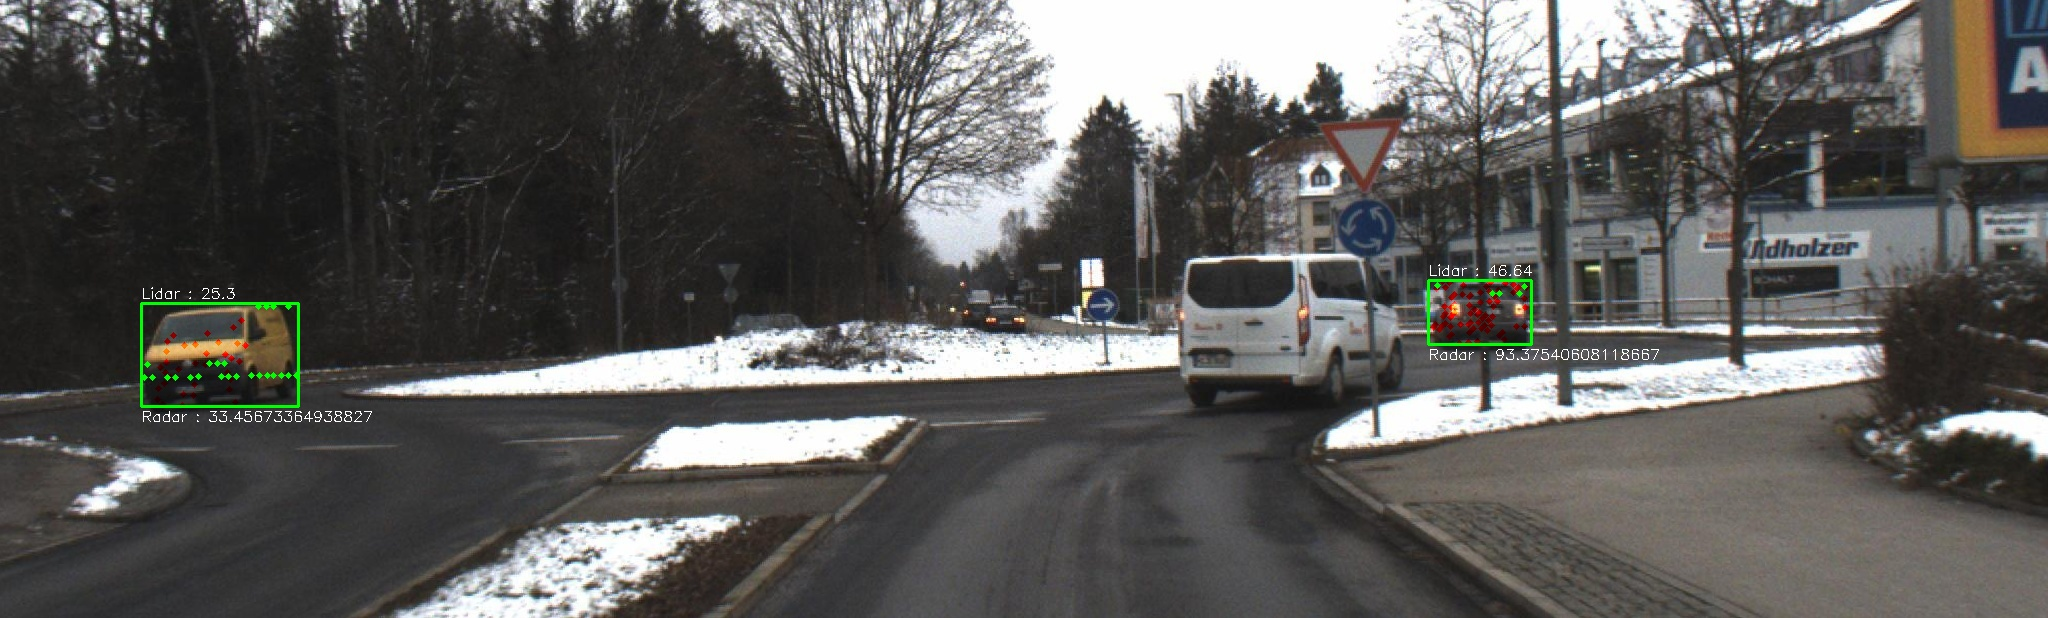

In [156]:
'''# Make a copy of the original image
blended_img_li_ra_copy = blended_img_li_ra.copy()

# Iterate through each bounding box in the DataFrame df
for index, row in df.iterrows():
    # Extract bounding box coordinates
    x_min = int(row['xmin'])
    y_min = int(row['ymin'])
    x_max = int(row['xmax'])
    y_max = int(row['ymax'])
    
    # Draw the bounding box on the copy of the image
    color = (0, 255, 0)  # Green color for the bounding box
    thickness = 2  # Thickness of the bounding box
    cv2.rectangle(blended_img_li_ra_copy, (x_min, y_min), (x_max, y_max), color, thickness)

    # Calculate the median values for Lidar and Radar within this bounding box
    lidar_median = np.median(com_lidar_by_bbox[f'BoundingBox_{index+1}'][:, 0])
    radar_median = np.median(com_radar_by_bbox[f'BoundingBox_{index+1}'][:, 0])


    # Add the median values to the copy image
    text_lidar = f"Lidar : {lidar_median}"
    text_radar = f"Radar : {radar_median}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    text_color = (255, 255, 255)  # White color for the text
    thickness = 1

    text_position_lidar = (x_min, y_min - 5)  # Position the Lidar text above the bounding box
    text_position_radar = (x_min, y_max + 15)  # Position the Radar text below the bounding box
    cv2.putText(blended_img_li_ra_copy, text_lidar, text_position_lidar, font, font_scale, text_color, thickness)
    cv2.putText(blended_img_li_ra_copy, text_radar, text_position_radar, font, font_scale, text_color, thickness)

# Convert the copy image to a format compatible with the Image object
img_bytes_copy = cv2.imencode('.jpg', blended_img_li_ra_copy)[1].tobytes()

# Display the copy image
display(Image(data=img_bytes_copy))'''

blended_img_li_ra_copy = blended_img_li_ra.copy()
# Iterate through each bounding box in the DataFrame df
for index, row in df.iterrows():
    # Extract bounding box coordinates
    x_min = int(row['xmin'])
    y_min = int(row['ymin'])
    x_max = int(row['xmax'])
    y_max = int(row['ymax'])

    # Check if there are Lidar points available for this bounding box
    lidar_bbox_key = f'BoundingBox_{index+1}'
    if lidar_bbox_key in com_lidar_by_bbox:
        lidar_points = com_lidar_by_bbox[lidar_bbox_key]
        print(lidar_points)
        if len(lidar_points) > 0:
            # Draw the bounding box on the copy of the image
            color = (0, 255, 0)  # Green color for the bounding box
            thickness = 2  # Thickness of the bounding box
            cv2.rectangle(blended_img_li_ra_copy, (x_min, y_min), (x_max, y_max), color, thickness)

            # Calculate the median values for Lidar and Radar within this bounding box
            lidar_median = np.median(abs(lidar_points[:, 1].astype(float)))  # Convert to float data type
            radar_bbox_key = f'BoundingBox_{index+1}'
            if radar_bbox_key in com_radar_by_bbox:
                radar_points = com_radar_by_bbox[radar_bbox_key]
                #print(radar_points)
                if len(radar_points) > 0:
                    radar_median = np.median(radar_points[:,1 ].astype(float))

                    # Add the median values to the copy image
                    text_lidar = f"Lidar : {lidar_median}"
                    text_radar = f"Radar : {radar_median}"
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 0.5
                    text_color = (255, 255, 255)  # White color for the text
                    thickness = 1

                    text_position_lidar = (x_min, y_min - 5)  # Position the Lidar text above the bounding box
                    text_position_radar = (x_min, y_max + 15)  # Position the Radar text below the bounding box
                    cv2.putText(blended_img_li_ra_copy, text_lidar, text_position_lidar, font, font_scale, text_color, thickness)
                    cv2.putText(blended_img_li_ra_copy, text_radar, text_position_radar, font, font_scale, text_color, thickness)

# Convert the copy image to a format compatible with the Image object
img_bytes_copy = cv2.imencode('.jpg', blended_img_li_ra_copy)[1].tobytes()

# Display the copy image
display(Image(data=img_bytes_copy))
